# Importing

## Importing modules

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

from keras.models import Sequential
from keras.layers import Activation, Dense

from keras.optimizers import SGD, adam, adagrad, rmsprop


## importing own code

In [50]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

In [51]:
def trainNetwork(network, trainingData, validationSplit, numberOfEpochs=50, batchSize=32, verboseSetting=-1):
    """
    hjhgj
    
    network is the Keras network to be trained.
    trainingData is the data to be trained with. It is a tupple with the index zero being the input data and index one being the target/output value.
    validationData is the data used to do validation.  It is a tupple with the index zero being the input data and index one being the target/output value.
    numberOfEpochs is the number of epochs the model will train for default is 50.
    batchSize is the size of the batches during gradiant decent defaul is 32.
    verboseSettings are the verbose settings default is -1 (which does nothing), 0 results in plots and above that normal rules apply.
    """
    
    #print(np.shape(trainingData[0]))
    #print(np.shape(trainingData[0][0]))
    #print(np.shape(trainingData[1]))
    
    #print(trainingData[0])
    
    fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split = validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))
    
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    if verboseSetting>=0:
        
        maximumValue = max(max(history['loss']), max(history['val_loss']))
        minimumValue = math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax1.legend()
        ax1.set_xlim(1, numberOfEpochs)
        ax1.set_ylim(0, maximumValue)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss (training and validation) vs the number of epochs.')
        
        ax2.plot(history['loss'], history['val_loss'])
        ax2.set_xlim(0, maximumValue)
        ax2.set_ylim(0, maximumValue)
        ax2.set_xlabel('Training loss')
        ax2.set_ylabel('Validation loss')
        ax2.set_title('Validation loss vs training loss.')
        
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax3.legend()
        ax3.set_xlim(1, numberOfEpochs)
        ax3.set_yscale('log')
        ax3.set_ylim(minimumValue, maximumValue)
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
        
        ax4.plot(history['loss'], history['val_loss'])
        ax4.set_xscale('log')
        ax4.set_xlim(minimumValue, maximumValue)
        ax4.set_yscale('log')
        ax4.set_ylim(minimumValue, maximumValue)
        ax4.set_xlabel('Training loss')
        ax4.set_ylabel('Validation loss')
        ax4.set_title('Validation loss vs training loss (logarithmic).')
        
        math.pow(math.log(min(min(history['loss']), min(history['val_loss'])), 10), 10)
        
        plt.show()
        history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [52]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)

In [53]:
def makeDenseModel(inputSize, settings, learningRate, lossFunction='mape', useBias=False, kernalInitializer='he_uniform'):
    """
    
    """
    model = Sequential()
    model.add(Dense(settings[0], input_dim=inputSize, use_bias=useBias, kernel_initializer=kernalInitializer))
    model.add(Activation('relu'))
    
    for i in range(1, len(settings)):
        model.add(Dense(settings[i], use_bias=useBias, kernel_initializer=kernalInitializer))
        model.add(Activation('relu'))
    
    model.add(Dense(1, use_bias=useBias, kernel_initializer=kernalInitializer))
    model.add(Activation('linear'))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model


In [54]:
def makeNetwork(inputSize, settings, learningRate, lossFunction='mape', kernalInitializer='he_uniform'):
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3], kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

# Getting data

In [55]:
filename = 'combinedDataPrepared'#'combinedDataPrepared'
orderOfMatrix = False# Make a list if you want to do the calculations yourself and make a other type of you want to import it

In [56]:
if (type(orderOfMatrix) == list):
    dataRaw = pd.read_json(filename + '.json', orient='columns')
    dataRaw['particleCoordinates'] = dataRaw['particleCoordinates'].apply(np.array)
    data = prepareDatabseForMachineLearningMultiprocessing(dataRaw, orderOfMatrix, filename + 'Prepared', amountOfCores)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
else:
    data = pd.read_json(filename + '.json', orient='columns')
    data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
    #data['eigenvalues'] = data['eigenvalues'].apply(list)

In [57]:
#data['potentialEnergy'] = data['potentialEnergy']-min(data['potentialEnergy'])

trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])
    targetData.append(trainingData['potentialEnergy'][i])

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]


In [58]:
#data.head()

In [59]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,230000.000000,230000.000000,230000.0,2.300000e+05
mean,114999.500000,25.487190,4.0,6.070610e+13
std,66395.425294,14.131367,0.0,2.831373e+16
min,0.000000,1.000061,4.0,-5.304560e-02
25%,57499.750000,13.237067,4.0,-2.850000e-08
50%,114999.500000,25.526970,4.0,1.575000e-07
75%,172499.250000,37.695345,4.0,4.950171e-04
max,229999.000000,49.999449,4.0,1.357338e+19


# Machine learning

## Model 1

In [60]:
inputSize = 8
settings = [['Dense', 64, 'relu', False], ['Dense', 64, 'relu', False], ['Dense', 64, 'relu', False], ['Dense', 64, 'relu', False], ['Dense', 1, 'linear', False]]
learningRate = 10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                512       
_________________________________________________________________
activation_31 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4096      
_________________________________________________________________
activation_32 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4096      
_________________________________________________________________
activation_33 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)               

Train on 147200 samples, validate on 36800 samples
Epoch 1/50
147200/147200 [==============================] - 12s 79us/step - loss: 4892464.5843 - val_loss: 3363330.3662
Epoch 2/50
147200/147200 [==============================] - 13s 86us/step - loss: 1731936.7120 - val_loss: 1164959.1986
Epoch 3/50
147200/147200 [==============================] - 12s 78us/step - loss: 1709994.8690 - val_loss: 192807.2479
Epoch 4/50
147200/147200 [==============================] - 11s 76us/step - loss: 1642460.0623 - val_loss: 1157632.4918
Epoch 5/50
147200/147200 [==============================] - 11s 74us/step - loss: 1399666.7483 - val_loss: 793446.4191
Epoch 6/50
147200/147200 [==============================] - 11s 75us/step - loss: 1324960.1981 - val_loss: 355875.8896
Epoch 7/50
147200/147200 [==============================] - 11s 75us/step - loss: 1171989.9868 - val_loss: 212975.5088
Epoch 8/50
147200/147200 [==============================] - 11s 74us/step - loss: 1079650.4187 - val_loss: 460895

C:\Users\heisz\anaconda3\envs\BEPGPU\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
C:\Users\heisz\anaconda3\envs\BEPGPU\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
C:\Users\heisz\anaconda3\envs\BEPGPU\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


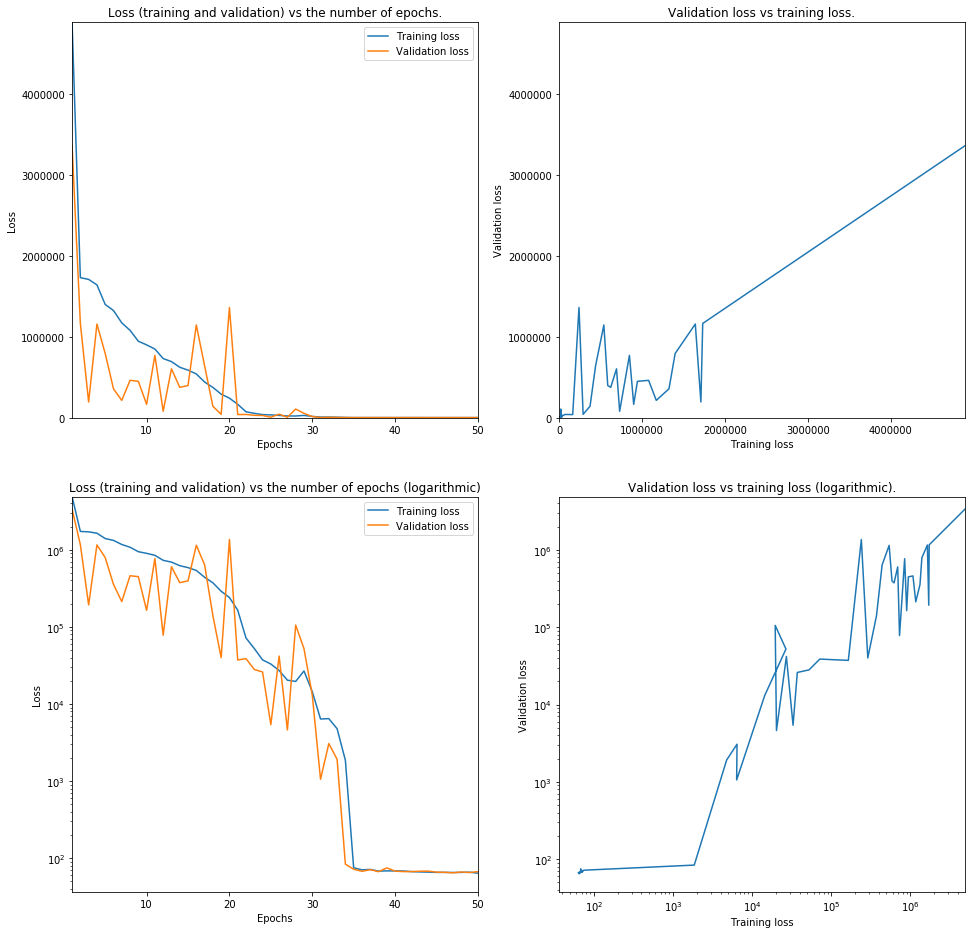

In [61]:
trainNetwork(model, trainingInput, 0.2, numberOfEpochs=50, batchSize=32, verboseSetting=1)
print()

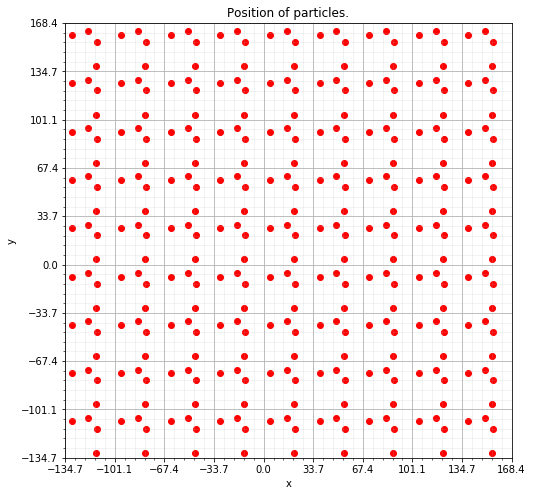

For index 0 Predicted 0.0 was -3.8900000000000004e-08


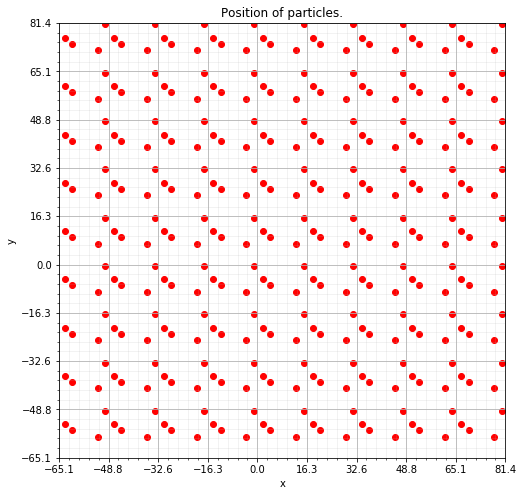

For index 3 Predicted 0.0 was 4.18e-06


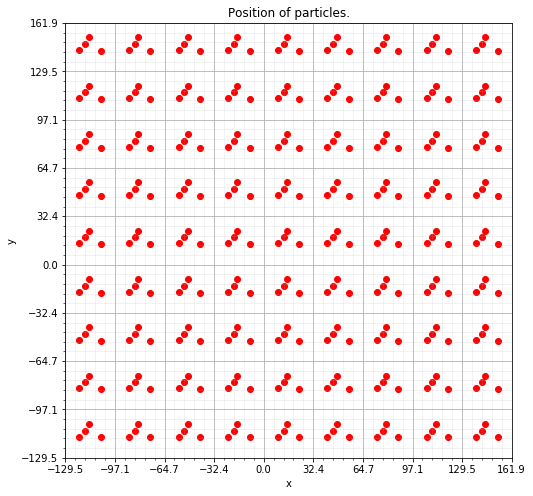

For index 11 Predicted 0.0 was 4.37e-08


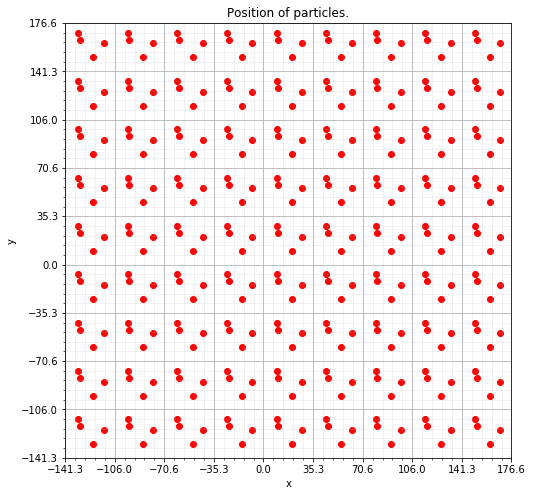

For index 17 Predicted 0.0 was 1.106e-07


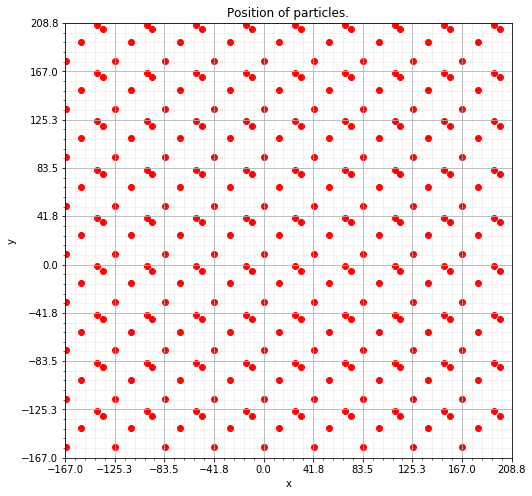

For index 18 Predicted 0.0 was 1.73e-08


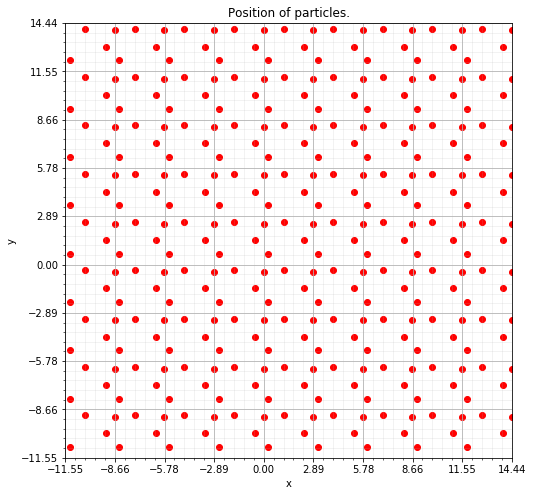

For index 19 Predicted 0.06795524 was 0.0507646244


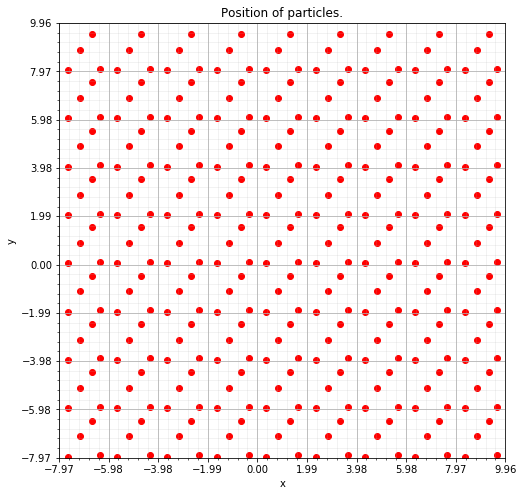

For index 25 Predicted 2.5616868 was 4.1695255857


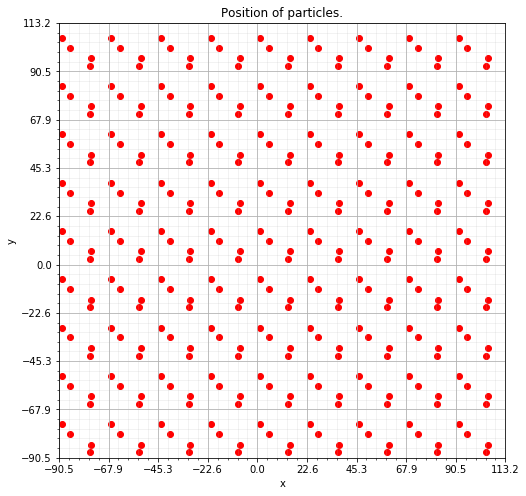

For index 26 Predicted 0.0 was 1.9272e-06


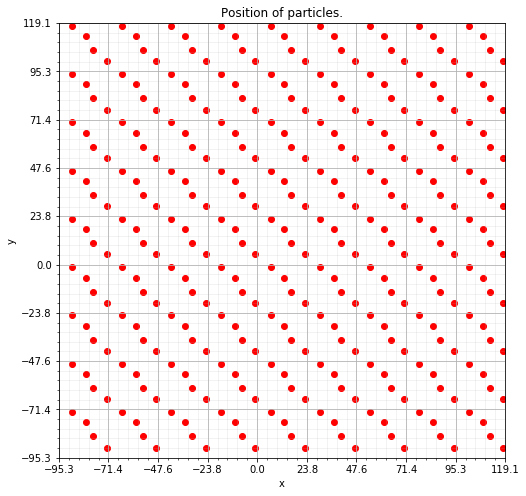

For index 27 Predicted 0.0 was -2.207e-07


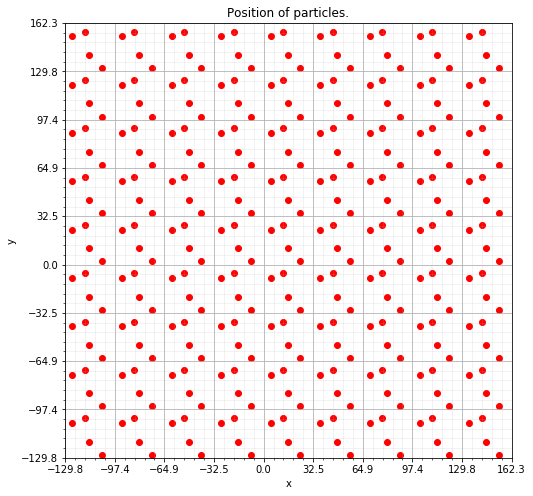

For index 34 Predicted 0.0 was -3.75e-08


In [62]:
for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

## Model 3

In [63]:
inputSize = 8
settings = [['Dense', 64, 'relu', False], ['Dense', 64, 'relu', False], ['Dense', 64, 'relu', False], ['Dense', 64, 'relu', True], ['Dense', 1, 'linear', False]]
learningRate = 10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                512       
_________________________________________________________________
activation_36 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4096      
_________________________________________________________________
activation_37 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4096      
_________________________________________________________________
activation_38 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)               

Train on 147200 samples, validate on 36800 samples
Epoch 1/50
147200/147200 [==============================] - 12s 83us/step - loss: 2403797.3283 - val_loss: 647007.0525
Epoch 2/50
147200/147200 [==============================] - 12s 83us/step - loss: 1414732.5245 - val_loss: 410121.3058
Epoch 3/50
147200/147200 [==============================] - 12s 83us/step - loss: 1353871.5744 - val_loss: 876637.2027
Epoch 4/50
147200/147200 [==============================] - 12s 82us/step - loss: 1354016.9507 - val_loss: 638354.1349
Epoch 5/50
147200/147200 [==============================] - 12s 82us/step - loss: 1412419.3614 - val_loss: 275699.6917
Epoch 6/50
147200/147200 [==============================] - 12s 82us/step - loss: 1370708.4900 - val_loss: 755246.3490
Epoch 7/50
147200/147200 [==============================] - 13s 86us/step - loss: 1244590.4272 - val_loss: 1345161.1910
Epoch 8/50
147200/147200 [==============================] - 12s 82us/step - loss: 1106406.3268 - val_loss: 231181.1

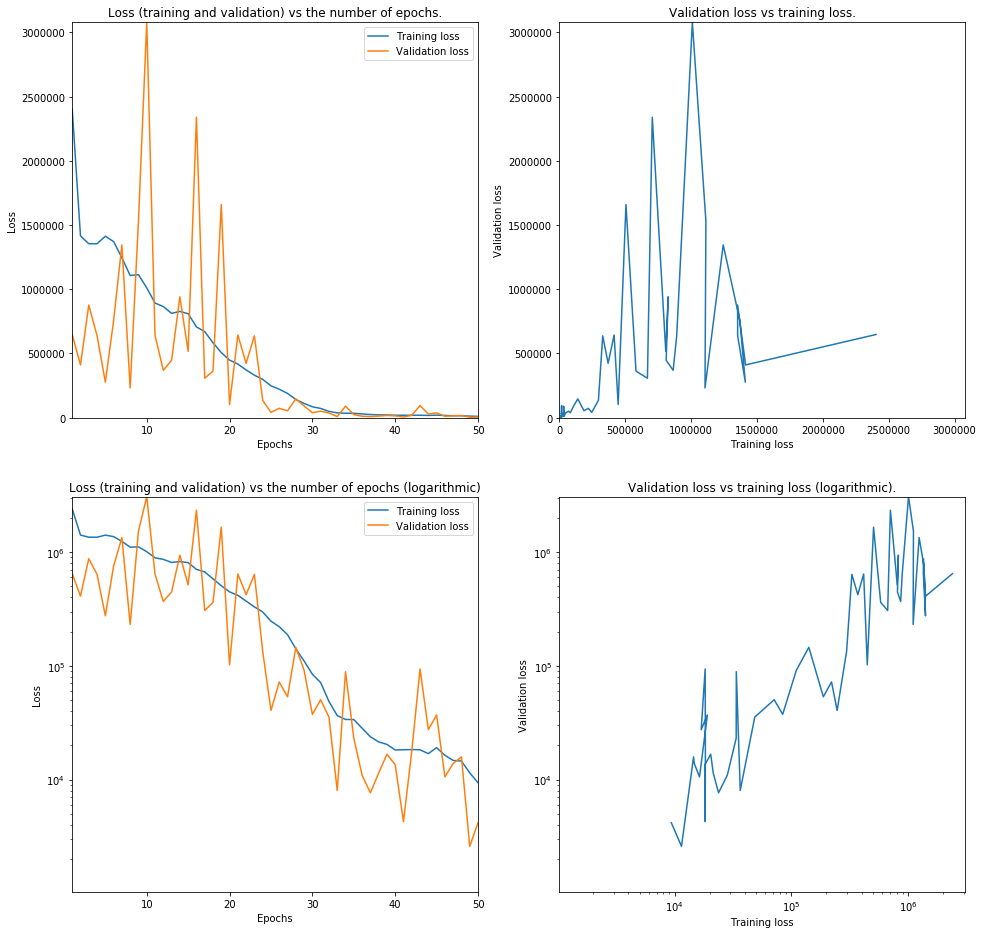

In [64]:
trainNetwork(model, trainingInput, 0.2, numberOfEpochs=50, batchSize=32, verboseSetting=1)
print()

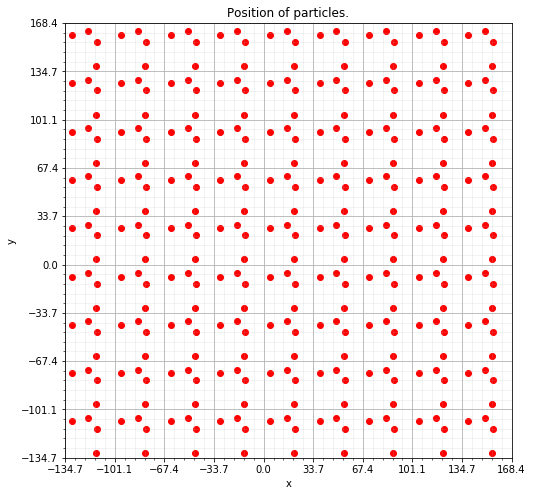

For index 0 Predicted 1.0659191e-05 was -3.8900000000000004e-08


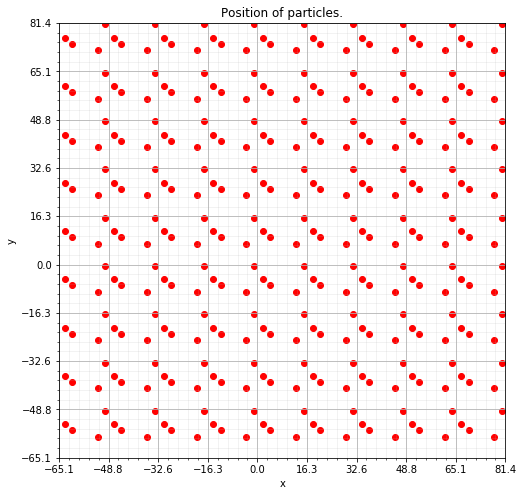

For index 3 Predicted 1.0659191e-05 was 4.18e-06


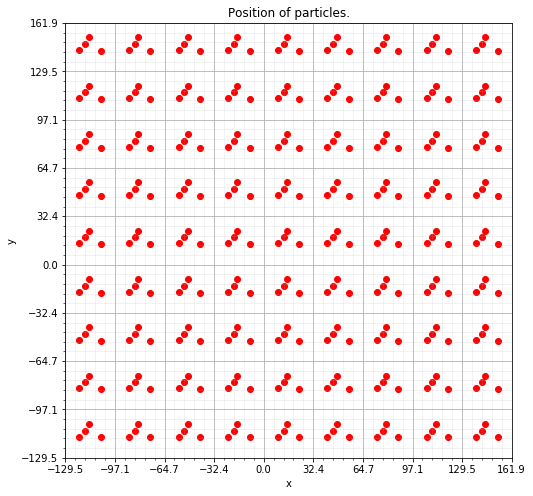

For index 11 Predicted 1.0659191e-05 was 4.37e-08


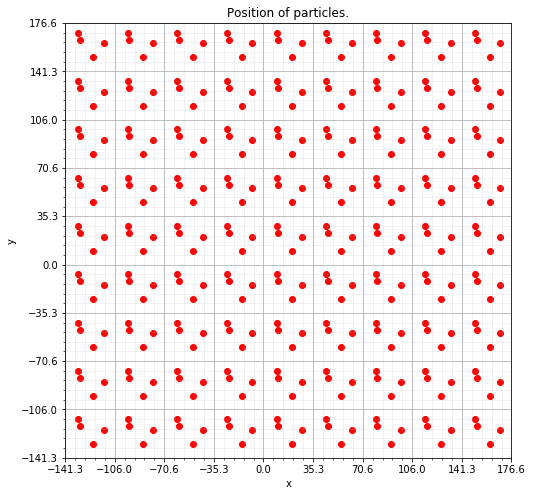

For index 17 Predicted 1.0659191e-05 was 1.106e-07


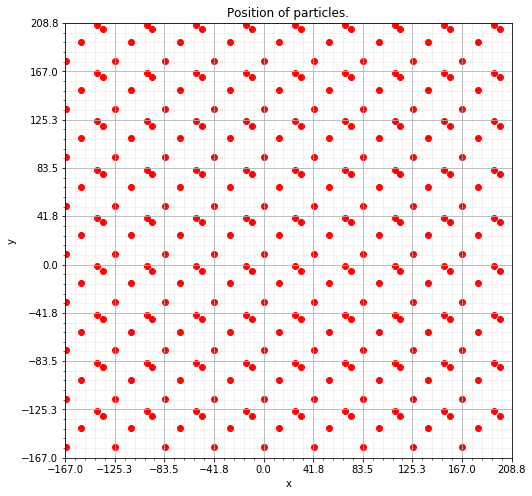

For index 18 Predicted 1.0659191e-05 was 1.73e-08


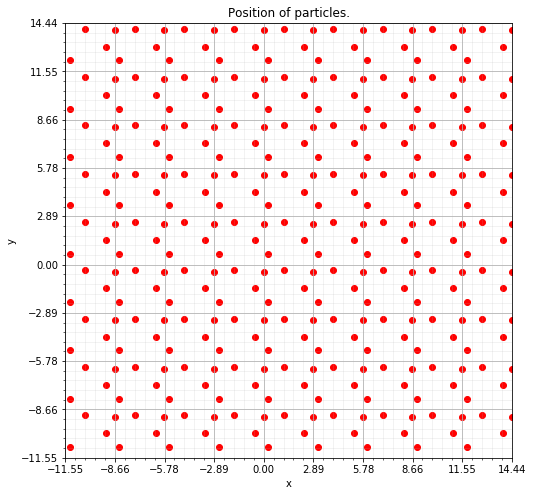

For index 19 Predicted 0.030409984 was 0.0507646244


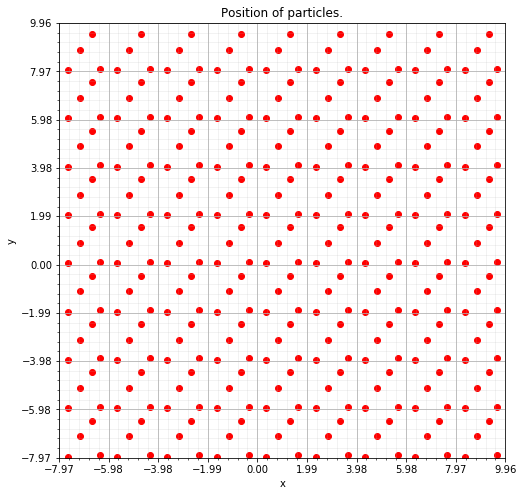

For index 25 Predicted 3.2065248 was 4.1695255857


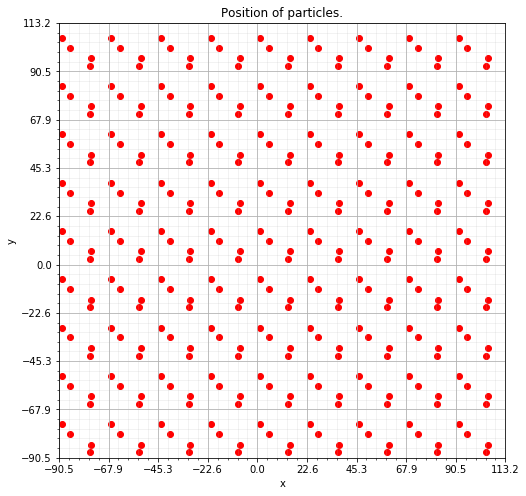

For index 26 Predicted 1.0659191e-05 was 1.9272e-06


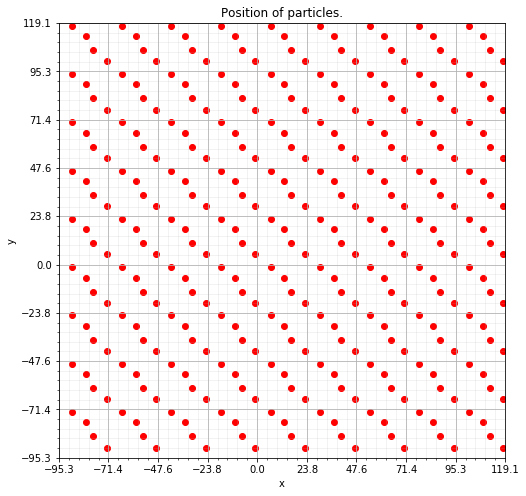

For index 27 Predicted 1.0659191e-05 was -2.207e-07


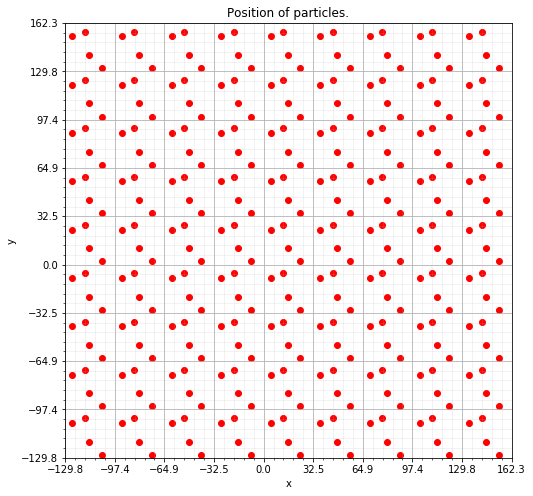

For index 34 Predicted 1.0659191e-05 was -3.75e-08


In [65]:
for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

## Model 5